# KNN Hyperparameter Analysis

## Objective

The main objective with this analysis is to better understand how the hyperparameter of KNN - Classification affect the model itself. This project will focus on two hyperparameter: the distance function and the k value.
<br><br>
Also, this analysis will be done in the "Sleep Health and Lifestyle Dataset" (found here: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset). This dataset includes data about health related indicators (such as quality of sleep and exercise), as well as a BMI qualitative variable (which we will try to predict with our model).<br><br>
Be aware that this data is synthetic, so no real life conclusions can be drawn from it.

## Downloading the data

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [101]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

## General Look at Data

In [102]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [104]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


Some important things to notice:<br>
- All quantitative variables have a mean close to median
- The data is from people with age between 27 and 59, so all data is from adults in working age
- Quality of sleep and Stress Level are on a scale from 1 to 10 (from original documentation). However, it's interesting to see that in both variable the min isn't 1 and the max isn't 10. I have two hypothesis for this: the data doesn't include info about people with very poor/ very good quality of sleep / stress level, or people just don't like answering very low or very high numbers
- Physical Activity Level is in min/day (from original documentation)
- Heart Rate is Resting Hear Rate (from original documentation). It doesn't seem to have a lot of variance in it. All values fall within what is considered a normal hear rate range

In [105]:
# Since "Sleep Disorder" has a lot of null values, let's take a closer look at it
df["Sleep Disorder"].value_counts()

Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

In [106]:
# Distribution of Gender (about 50% each)
df["Gender"].value_counts()

Gender
Male      189
Female    185
Name: count, dtype: int64

In [107]:
# Distribution of Professions
df["Occupation"].value_counts()

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

Clearly the dataset focus in a few professions more than others. We can expect the model to have a better accuracy for nurses, doctors and engineers than for sofware engineers, for example.

In [108]:
# Distribution of BMI classes
df["BMI Category"].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

The difference between "Normal" and "Normal Weight" isn't very clear. The discussions in the original webpage of the dataset in Kaggle also don't clarify what they are. It's probably a good idea to merge these too.
<br><br>
Other than than, the distribution seems fine. It's expected to see more people in the "normal" weight category than overweight, and overweight people than obese ones.

Another important thing to mention is that blood pressure, the way is presented, doesn't work as a quantitative variable, but also can't really be used as a quantitative variable either. Because of this, it will be dropped during data cleaning.

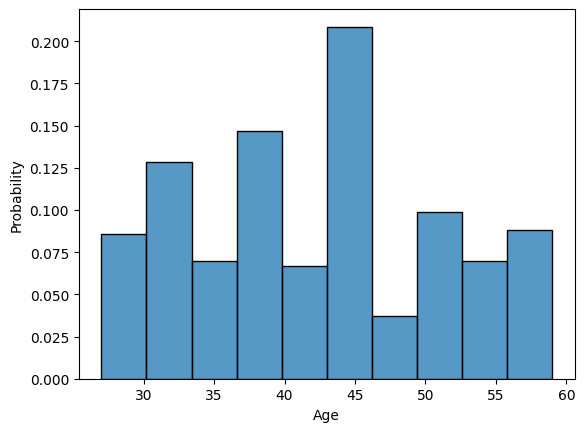

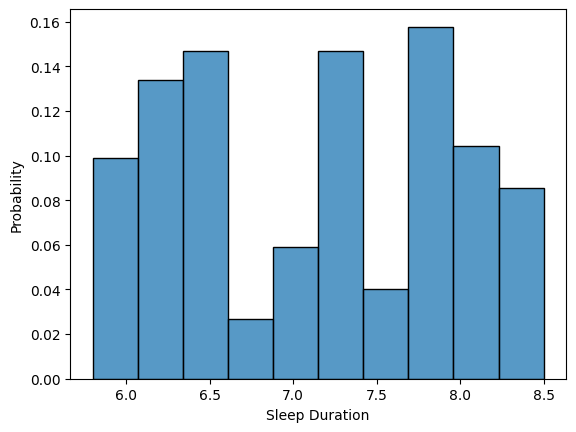

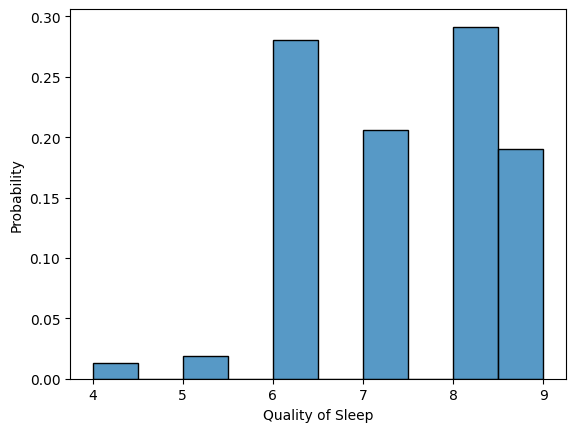

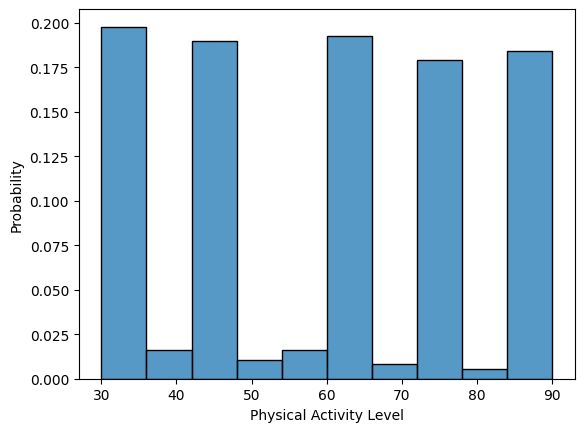

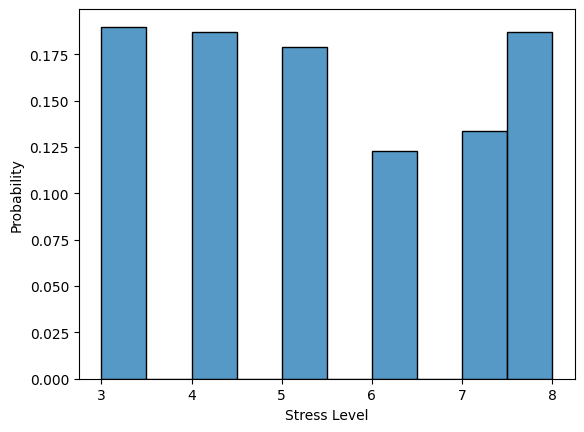

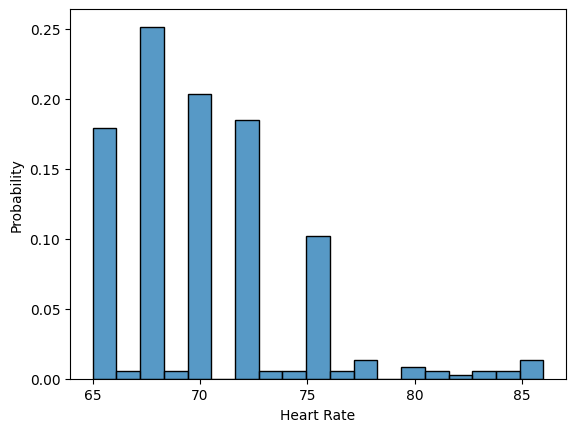

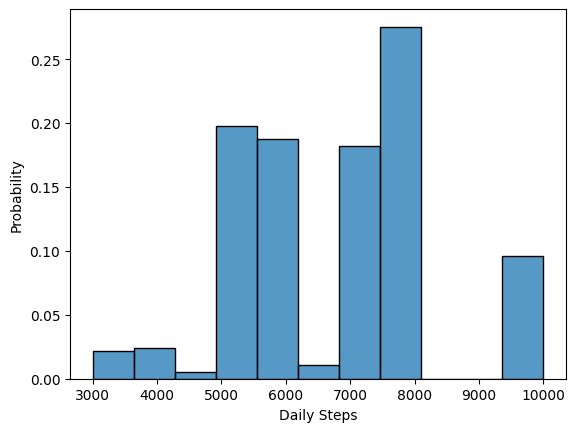

In [109]:
# Histogram of quantitative data data
removed = ["Person ID", "Gender", "Occupation", "BMI Category", "Sleep Disorder", "Blood Pressure"]
for i, col in enumerate(df.columns):
    if col in removed:
        continue
    plt.figure(i)
    sns.histplot(x=col, data=df, stat="probability")

## Data Cleaning

In [110]:
# Copy of original dataset in case we want to reverse the changes
df_original = df.copy()

In [111]:
# Taking a look at the documentation of the dataset, it says that there are three classes: None, Insomnia, Sleep Apnea
# Clearly, the "None" class was included as NA values, so let's fix that
df["Sleep Disorder"].fillna("None", inplace=True)

In [112]:
df["Sleep Disorder"].value_counts()

Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

In [113]:
# We should have no null values now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [114]:
# As explained before, we will drop "Blood Pressure from the dataset"
df = df.drop("Blood Pressure", axis=1)
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea


In [115]:
# Since we don't know what is the difference between "Normal" and "Normal Weight", it's plausible to make them the same
df["BMI Category"] = df["BMI Category"].replace({"Normal Weight": "Normal"})
df["BMI Category"].value_counts()

BMI Category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64

In [116]:
# Since we don't want to include Person ID as a parameter for our predictions, we will also drop it
df = df.drop("Person ID", axis=1)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea


In [117]:
# Turning qualitative variables in quantitative ones using one-hot encoding

# Occupation
one_hot = pd.get_dummies(df["Occupation"])
df = df.join(one_hot)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Doctor,Engineer,Lawyer,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,...,False,False,False,False,False,False,False,False,True,False
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,True,False,False,False,False,False,False,False,False,False
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,True,False,False,False,False,False,False,False,False,False
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,False,False,False,True,False,False,False,False
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False


In [118]:
#  Sleep disorder
one_hot = pd.get_dummies(df["Sleep Disorder"])
df = df.join(one_hot)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,...,False,False,False,False,False,True,False,False,True,False
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,False,False,False,False,False,False,False,False,True,False
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,False,False,False,False,False,False,False,False,True,False
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,True,False,False,False,False,False,False,True
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True


In [119]:
# Gender (can be done manually)
df["Gender"] = df["Gender"].replace({"Female": 0, "Male": 1})

In [120]:
df.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Daily Steps', 'Sleep Disorder', 'Accountant', 'Doctor', 'Engineer',
       'Lawyer', 'Manager', 'Nurse', 'Sales Representative', 'Salesperson',
       'Scientist', 'Software Engineer', 'Teacher', 'Insomnia', 'None',
       'Sleep Apnea'],
      dtype='object')

In [121]:
# Dropping old parameters
df = df.drop("Occupation", axis=1)
df = df.drop("Sleep Disorder", axis=1)

In [122]:
df

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Accountant,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
0,1,27,6.1,6,42,6,Overweight,77,4200,False,...,False,False,False,False,False,True,False,False,True,False
1,1,28,6.2,6,60,8,Normal,75,10000,False,...,False,False,False,False,False,False,False,False,True,False
2,1,28,6.2,6,60,8,Normal,75,10000,False,...,False,False,False,False,False,False,False,False,True,False
3,1,28,5.9,4,30,8,Obese,85,3000,False,...,False,False,True,False,False,False,False,False,False,True
4,1,28,5.9,4,30,8,Obese,85,3000,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0,59,8.1,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True
370,0,59,8.0,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True
371,0,59,8.1,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True
372,0,59,8.1,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True


## Splitting the Training and the Test Datasets

In [123]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)  # I will set the seed to a specific state just to make comparisons more clear

In [124]:
len(train_set), len(test_set)

(299, 75)

array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Sleep Duration'}>],
       [<Axes: title={'center': 'Quality of Sleep'}>,
        <Axes: title={'center': 'Physical Activity Level'}>,
        <Axes: title={'center': 'Stress Level'}>],
       [<Axes: title={'center': 'Heart Rate'}>,
        <Axes: title={'center': 'Daily Steps'}>, <Axes: >]], dtype=object)

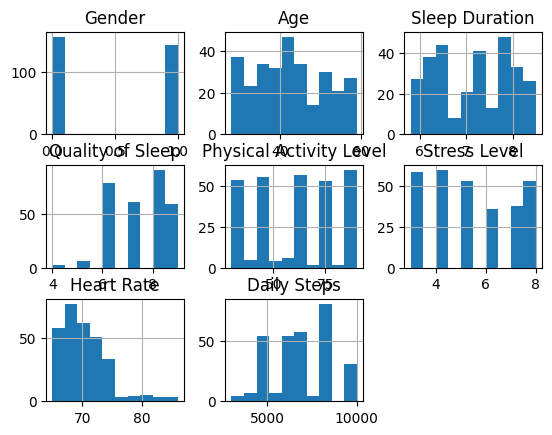

In [125]:
# Checking distributions
train_set.hist()

array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Sleep Duration'}>],
       [<Axes: title={'center': 'Quality of Sleep'}>,
        <Axes: title={'center': 'Physical Activity Level'}>,
        <Axes: title={'center': 'Stress Level'}>],
       [<Axes: title={'center': 'Heart Rate'}>,
        <Axes: title={'center': 'Daily Steps'}>, <Axes: >]], dtype=object)

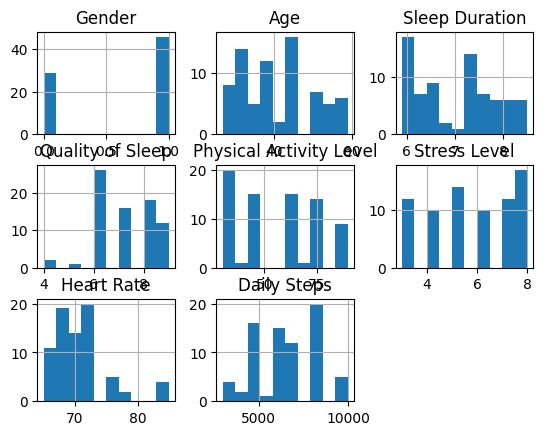

In [126]:
test_set.hist()

As we can see, the distributions are similar in train and test datasets (what is to be expected). However, the "Sleep Duration" variable does seem to be quite different, which might affect the predictions of our models.

## Analysing Data more Depply

In [127]:
# Creating a copy of train_set, since we might make some changes to it
df = train_set.copy()

In [128]:
df

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Accountant,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
192,1,43,6.5,6,45,7,Overweight,72,6000,False,...,False,False,False,True,False,False,False,True,False,False
75,1,33,6.0,6,30,8,Normal,72,5000,False,...,False,False,False,False,False,False,False,False,True,False
84,1,35,7.5,8,60,5,Normal,70,8000,False,...,False,False,False,False,False,True,False,False,True,False
362,0,59,8.2,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True
16,0,29,6.5,5,40,7,Normal,80,4000,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,33,6.1,6,30,8,Normal,72,5000,False,...,False,False,False,False,False,False,False,False,True,False
106,0,37,6.1,6,42,6,Overweight,77,4200,False,...,False,True,False,False,False,False,False,False,True,False
270,0,49,6.1,6,90,8,Overweight,75,10000,False,...,False,True,False,False,False,False,False,False,False,True
348,0,57,8.2,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True


In [145]:
# Looking for correlation between quantitative variables
variables = ["Age", "Sleep Duration", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"]
corr_matrix = df[variables].corr()
corr_matrix

,Age,Sleep Duration,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
Age,1.000000,0.328879,0.165018,-0.401102,-0.182901,0.015201
Sleep Duration,0.328879,1.000000,0.178533,-0.801017,-0.510034,-0.094479
Physical Activity Level,0.165018,0.178533,1.000000,0.010903,0.184005,0.763810
Stress Level,-0.401102,-0.801017,0.010903,1.000000,0.682697,0.247608
Heart Rate,-0.182901,-0.510034,0.184005,0.682697,1.000000,0.045772
Daily Steps,0.015201,-0.094479,0.763810,0.247608,0.045772,1.000000


High Positive Correlations:
- Daily Steps and Physical Activity Level (76%)
- Heart Rate and Stress Level (68%)
- Sleep Duration and Age (32%)<br><br>
High Negative Correlations
- Stress Level and Age (40%)
- Stress Level and Sleep Duration (80%)
- Heart Rate and Sleep Duration (51%)<br><br>
In general, there's seems to be a lot of correlation between the data. This will problably negatively impact the predictions, since this creates a lot of redundant predictors in a dataset with already few predictors.

## Testing the Models

### KNN Model with Euclidian Distance

In [146]:
# separating X and Y
X = train_set.drop("BMI Category", axis=1)
Y = train_set["BMI Category"]

In [148]:
# Training the model
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, Y)

KNeighborsClassifier(n_neighbors=3)

In [153]:
# Accuracy in test dataset
X_test = test_set.drop("BMI Category", axis=1)
Y_test = test_set["BMI Category"]
neigh.score(X_test.values, Y_test)

/home/robertotomchak/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9866666666666667

In [155]:
predictions = neigh.predict(X_test.values)
labels = Y_test.values
results = pd.DataFrame({"Predictions": predictions, "Labels": labels})
results

/home/robertotomchak/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


,Predictions,Labels
0,Normal,Normal
1,Normal,Normal
2,Normal,Normal
3,Normal,Normal
4,Normal,Normal
...,...,...
70,Normal,Normal
71,Overweight,Overweight
72,Normal,Normal
73,Overweight,Overweight
